This dataset you received contains information on over 800+ fashion products. The data includes fields such as product ID,identifier ,selling_price,original_price,currency,availability,color,category,breadcrumbs,country,language,average_rating,reviews_count.

Task 1: 
    Please analyze the data in order to find which colors are the most popular among different genders and age groups, in the end please create a dashboard to show your results.
    
Task 2:
    Please analyze the correlation between ratings and reviews to determine which factors are most important to customers, in the end please create a dashboard to show your results.
    
Task 3:
    Please create a modell to predict which combinatin of selling_price,color,category,breadcrumbs could be most popular products for next year?

In [1]:
#Requirements 

#pandas==1.4.4
#numpy==1.21.5
#scipy==1.9.1
#seaborn==0.11.2
#matplotlib==3.5.2
#statsmodels==0.13.2
#scikit-learn==1.0.2
#seaborn==0.11.2




In [2]:
#importing data and observe
import pandas as pd
import scipy.stats
import numpy as np
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

nan = np.nan


import warnings
warnings.filterwarnings("ignore")


FILE_PATH = 'C:\учеба\Siemens\Fashion_Retail.csv'
raw_data = pd.read_csv(FILE_PATH, encoding= 'unicode_escape')
raw_data.head()

,product ID,identifier,selling_price,original_price,currency,availability,color,category,breadcrumbs,country,language,average_rating,reviews_count
0,100,FJ5089,40,NaN,euro,InStock,Black,Clothing,Women/Clothing,Germany,German,4.5,35
1,101,BC0770,150,NaN,euro,InStock,Grey,Shoes,Women/Shoes,Germany,German,4.8,4
2,102,GC7946,70,NaN,euro,InStock,White,Clothing,Kids/Clothing,Germany,German,4.9,42
3,103,FV4744,160,NaN,euro,InStock,Black,Shoes,Five Ten/Shoes,Germany,German,3.7,7
4,104,GM0239,65,NaN,euro,InStock,Blue,Clothing,Men/Clothing,Germany,German,4.7,11


# Task 1: Please analyze the data in order to find which colors are the most popular among different genders and age groups, in the end please create a dashboard to show your results.

In [3]:
#get general information on our data
raw_data.info()
#so we observe that we have missing value on original_price

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product ID      845 non-null    int64  
 1   identifier      845 non-null    object 
 2   selling_price   845 non-null    int64  
 3   original_price  829 non-null    float64
 4   currency        845 non-null    object 
 5   availability    845 non-null    object 
 6   color           845 non-null    object 
 7   category        845 non-null    object 
 8   breadcrumbs     845 non-null    object 
 9   country         845 non-null    object 
 10  language        845 non-null    object 
 11  average_rating  845 non-null    float64
 12  reviews_count   845 non-null    int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 85.9+ KB


In [4]:
#get some general statistic first glance
raw_data.describe()

,product ID,selling_price,original_price,average_rating,reviews_count
count,845.000000,845.000000,829.000000,845.000000,845.000000
mean,522.000000,53.192899,69.008444,4.608402,426.178698
std,244.074784,31.411645,40.490127,0.293795,1229.158277
min,100.000000,9.000000,14.000000,1.000000,1.000000
25%,311.000000,28.000000,35.000000,4.500000,19.000000
50%,522.000000,48.000000,65.000000,4.700000,68.000000
75%,733.000000,70.000000,90.000000,4.800000,314.000000
max,944.000000,240.000000,300.000000,5.000000,11750.000000


# Preprocessing the data

In [5]:
def restore_missing_value(significant_columns_data_clean):
    """
    As soon as missing values is in original_price column, we will use columns selling_price, selling_price, reviews_count 
    for prediction of missing values
    The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach
    
    """    
    
    to_predict_nulls_array = np.array([significant_columns_data_clean['selling_price'], significant_columns_data_clean['original_price'],
              significant_columns_data_clean['selling_price'], significant_columns_data_clean['reviews_count']])

    to_predict_nulls_array = np.transpose(to_predict_nulls_array)

    imputer = KNNImputer(n_neighbors=3, weights="uniform")
    predicted_nulls_array = imputer.fit_transform(to_predict_nulls_array)
    
    

    return predicted_nulls_array






In [6]:
def standartize_data(no_duplicates_data):
    """
    Standartisation of reviews_count and average_rating for summarasing in new value=popularity
    """
    

    #Locking our two columns
    no_duplicates_data_check=no_duplicates_data.loc[:,  ['reviews_count','average_rating']] 
    
    #Now we need to stundartise our data('reviews_count','average_rating') to the range of (0,1)
    X_train = np.array(no_duplicates_data_check)
    
    #going to stundartise our data to the range of (0,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train_minmax = min_max_scaler.fit_transform(X_train)
    
    #And now, as we standartised the data, making new column 'popularity', and putting the summation there
    no_duplicates_data['popularity'] = np.sum(X_train_minmax, axis = 1)  
   

    return no_duplicates_data



In [7]:
def drop_outliners(no_duplicates_data_scaled):
    """
    As soon as there are can be outliners, we need to drop them
    """
        
    q1 = no_duplicates_data_scaled['popularity'].quantile(0.25)
    q3 = no_duplicates_data_scaled['popularity'].quantile(0.75)

    iqr = q3-q1
    lower_fence = q1-1.5*iqr
    upper_fence = q3+1.5*iqr
    
    
    non_outliners_data = no_duplicates_data_scaled.loc[~((no_duplicates_data_scaled['popularity']<lower_fence) | 
                                                     (no_duplicates_data_scaled['popularity']>upper_fence))]

    #and reseting indexes
    non_outliners_data.reset_index().drop(['index'], axis=1)


    return non_outliners_data

In [8]:
def preprocess_Data(raw_data):
    """
    Preprocessing raw data set into ready to analize data
    """
    #from the column 'breadcrumbs' we can get information about gender, and also get additional column 'clothesType' 
    raw_data['gender'] = raw_data['breadcrumbs'].str.split("/").str[0]
    raw_data['clothesType'] = raw_data['breadcrumbs'].str.split("/").str[1]
    
    #as soon as we have Multicolor in different way of typing - make the common name for it - Multi
    raw_data.loc[raw_data['color']=='Multicolor', ['color']]='Multi'
    
    #Making additional column Gender 
    raw_data['ageGroup']  = raw_data['gender'].replace(['Women', 'Men'], 'adult')
    
    raw_data['ageGroup']  = raw_data['ageGroup'].replace(['Kids'], 'children')
    
    #As soon as it is the same, we can drop it
    # Dropping all columns, which has no useful information for us
    # As soon as columns currency', 'country', 'language' has the only one value - we can drop it

    significant_columns_data = raw_data.drop([ 'currency', 'clothesType',  'country', 'language'] , axis=1, inplace=False)

    #dropping all values from ageGroup which is not adultn or children
    significant_columns_data_clean = significant_columns_data.loc[~((significant_columns_data['ageGroup']!='adult')
                                                                &(significant_columns_data['ageGroup']!='children'))]

    #and reseting the index
    significant_columns_data_clean.reset_index().drop(['index'], axis=1)
    
    predicted_nulls_array = restore_missing_value(significant_columns_data_clean)
    
    #adding values to our table
    significant_columns_data_clean.loc[:, ('original_price')]=predicted_nulls_array[:, 1].round(0).astype(int)
    
    #make sure there are no duplicate rows in our table
    no_duplicates_data = significant_columns_data_clean.drop_duplicates(subset = ['product ID'])
    
    no_duplicates_data.reset_index().drop(['index'], axis=1)
    
    #it can be logically assumed that the popularity of a particular color is made up not only of the rating, 
    #but also of the number of reviews for the product. Therefore, we introduce a new value - popularity. 
    #To do this, we need to standardize these two columns, since the data is too different in dimensions.

    
    no_duplicates_data_scaled = standartize_data(no_duplicates_data)
    
    non_outliners_data=drop_outliners(no_duplicates_data_scaled)


    return non_outliners_data






In [9]:
def anova_preproc(non_outliners_data):
    '''Lets separate the three samples (one for age and gender category) into a variable each. And use Anova
    '''
    Women = non_outliners_data[non_outliners_data['gender'] == 'Women']['popularity']
    Men = non_outliners_data[non_outliners_data['gender'] == 'Men']['popularity']
    Kids = non_outliners_data[non_outliners_data['gender'] == 'Kids']['popularity']
    
    #Now, run a one-way ANOVA.
    f_statistic, p_value = scipy.stats.f_oneway(Women, Men, Kids)
    
    return f_statistic,p_value

In [10]:
def preproc_for_regression(non_outliners_data):
    regressionAnalys = non_outliners_data.loc[:, ['selling_price', 'color', 'category', 'gender', 'popularity']]
    
    # To include the categorical data in the regression, we create dummies
    data_with_dummies = pd.get_dummies(regressionAnalys, drop_first=True)
    
    # To make the code a bit more parametrized,  declare a new variable that will contain the preferred columns order

    cols = ['popularity','selling_price', 'color_Black', 'color_Blue',
       'color_Burgundy', 'color_Gold', 'color_Green', 'color_Grey',
       'color_Multi', 'color_Orange', 'color_Pink', 'color_Purple',
       'color_Red', 'color_Turquoise', 'color_White', 'color_Yellow',
       'category_Clothing', 'category_Shoes', 'gender_Men',
       'gender_Women']
    
    # To implement the reordering, create a new df = data_preprocessed, 
    #which is equal to the old one but with the new order of features

    data_preprocessed = data_with_dummies[cols]
    return data_preprocessed

In [11]:
def linear_regression(data_preprocessed):
    #Declare the inputs and the targets
    # The target(s) (dependent variable) is 'popularity'
    targets = data_preprocessed['popularity']

    # The inputs are everything BUT the dependent variable, so we can simply drop it
    inputs = data_preprocessed.drop(['popularity'],axis=1)
    
    #Scale the data
    # Create a scaler object
    scaler = StandardScaler()

    # Fit the inputs (calculate the mean and standard deviation feature-wise)
    scaler.fit(inputs)
    
    # Scale the features and store them in a new variable (the actual scaling procedure)
    inputs_scaled = scaler.transform(inputs)
    
    # Split the variables with an 80-20 split and some random state
    x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)
    
    # Create a linear regression object
    reg = LinearRegression()
    # Fit the regression with the scaled TRAIN inputs and targets
    reg.fit(x_train,y_train)
    
    y_hat = reg.predict(x_train)
    
    
    return y_hat, x_train, x_test, y_train, y_test, reg, inputs, targets

In [12]:
non_outliners_data = preprocess_Data(raw_data)
non_outliners_data.head()

,product ID,identifier,selling_price,original_price,availability,color,category,breadcrumbs,average_rating,reviews_count,gender,ageGroup,popularity
0,100,FJ5089,40,47,InStock,Black,Clothing,Women/Clothing,4.5,35,Women,adult,0.877894
1,101,BC0770,150,157,InStock,Grey,Shoes,Women/Shoes,4.8,4,Women,adult,0.950255
2,102,GC7946,70,87,InStock,White,Clothing,Kids/Clothing,4.9,42,Kids,children,0.978490
4,104,GM0239,65,87,InStock,Blue,Clothing,Men/Clothing,4.7,11,Men,adult,0.925851
5,105,FX7449,110,143,InStock,Grey,Shoes,Women/Shoes,4.9,30,Women,adult,0.977468


[Text(0.5, 0, 'Normal Distribution'), Text(0, 0.5, 'Frequency')]

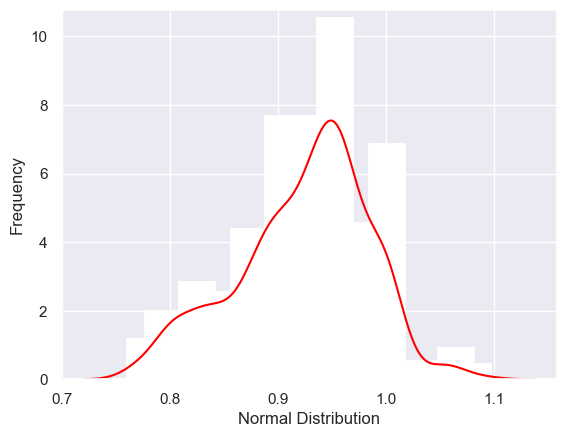

In [13]:
#Lets check if we can say that distribution is normal
ax = sns.distplot(non_outliners_data['popularity'],
                  bins=20,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')
#Let it say we can assume it is normal(bel shapped)

Now we can state our hypothesis

*   $H\_0: µ\_1 = µ\_2 = µ\_3$ (the three group means are equal: adult Women, Adult Men, Kids)
*   $H\_1:$ At least one of the means differ


In [14]:
f_statistic,p_value = anova_preproc(non_outliners_data)

In [15]:
print("F_Statistic: {0}, P-Value: {1}".format(f_statistic,p_value))

F_Statistic: 7.315097363652796, P-Value: 0.0007190957528595708


Conclusion: Since the p-value is less than 0.05, we will reject the null hypothesis 
as there is significant evidence that at least one of the means differ.

In [16]:
#Lets examine Popularity by gender Group mean 
genderGroupMeanPopularity = non_outliners_data.groupby(['gender']).popularity.mean()
genderGroupMeanPopularity

gender
Kids     0.938583
Men      0.928335
Women    0.914788
Name: popularity, dtype: float64

<AxesSubplot:xlabel='gender', ylabel='popularity'>

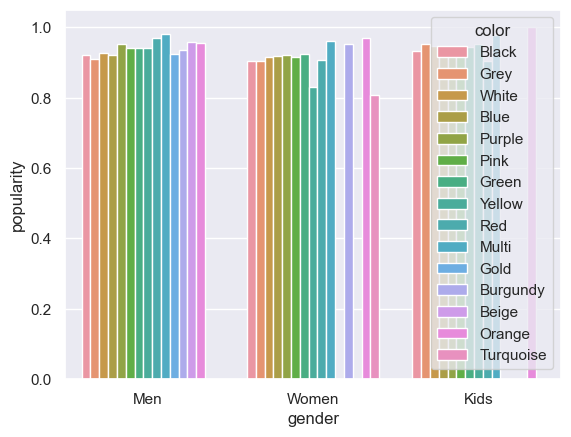

In [17]:
#Lets make visualisation on the popularity of colors amoung Women, Men, Kids

sns.barplot(
    x="gender", 
    y="popularity", 
    hue="color", 
    ci=None,
    order=["Men","Women", "Kids"],
    data=non_outliners_data
)





<AxesSubplot:xlabel='ageGroup', ylabel='popularity'>

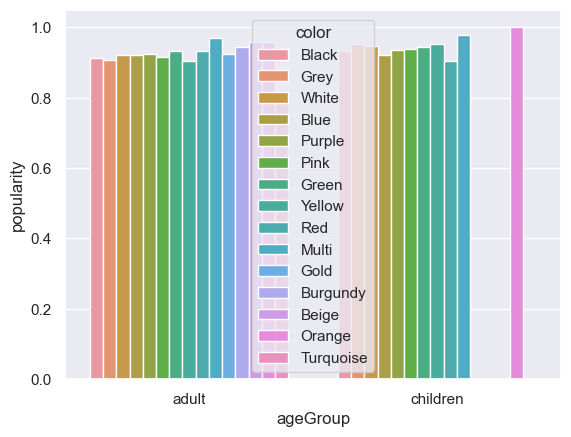

In [18]:
sns.barplot(
    x="ageGroup", 
    y="popularity", 
    hue="color", 
    ci=None,
    data=non_outliners_data
)

### Conclusion on Task 1: analyze the data in order to find which colors are the most popular among different genders and age groups

Due to the data - we observe, that the three group means are not equal: adult Women, Adult Men, Kids(there is significant evidence that at least one of the means differ due to the Anova)
  
As we can see, among the adult - high popularity is at multicolor option. 
while for kids high popularity is for orange color

We also see, that orange is also popular for Women/adult.As much as multicolor is the high option for kids as well

# Task 2: Please analyze the correlation between ratings and reviews to determine which factors are most important to customers, in the end please create a dashboard to show your results.

Correlation: Using the dataset, Is rating evaluation score correlated with review count?

State the hypothesis:

*   $H\_0:$ rating evaluation score is not correlated with review count
*   $H\_1:$ rating evaluation score is correlated with review count

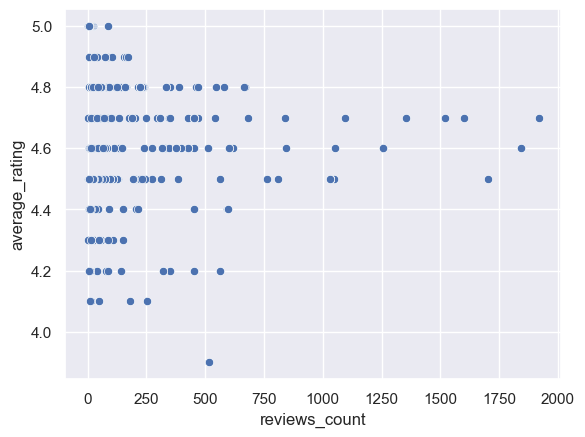

In [19]:
#Since they are both continuous variables we can use a pearson correlation test and draw a scatter plot
ax = sns.scatterplot(x="reviews_count", y="average_rating", data=non_outliners_data)

In [20]:
#Lets see the pearson correlation
scipy.stats.pearsonr(non_outliners_data['reviews_count'], non_outliners_data['average_rating'])

PearsonRResult(statistic=-0.14807598309176218, pvalue=0.00010266684983972688)

Conclusion: Since the p-value  < 0.05, 
we reject the Null hypothesis and conclude that there exists a relationship between reviews_count and average_rating score.

A negative correlation between two variables means that the variables move in opposite directions. An increase in one variable leads to a decrease in the other variable and vice versa

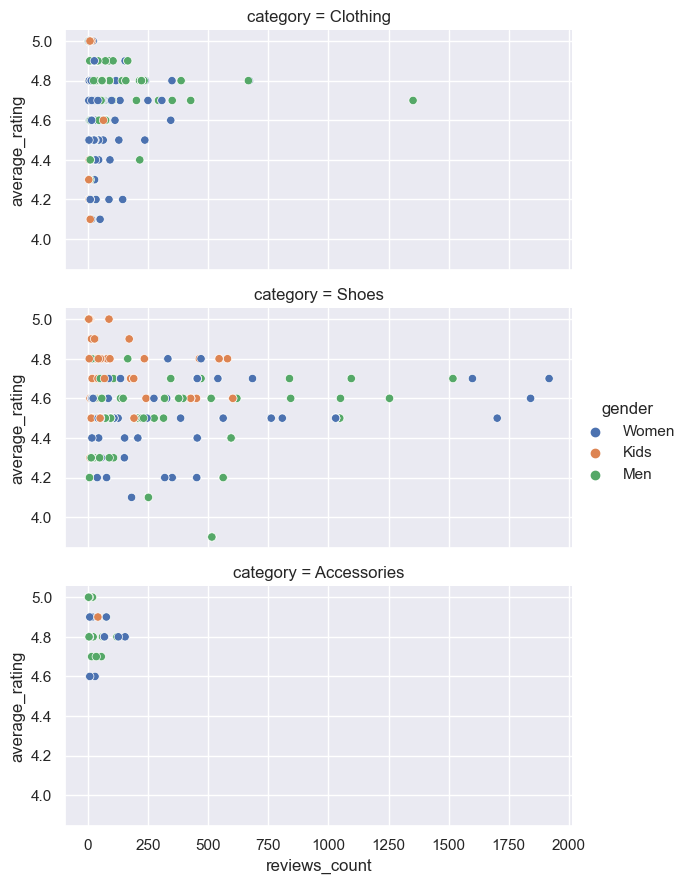

In [21]:
sns.relplot(x="reviews_count", y="average_rating", hue="gender",
            row="category",
            data=non_outliners_data, height = 3, aspect = 2)

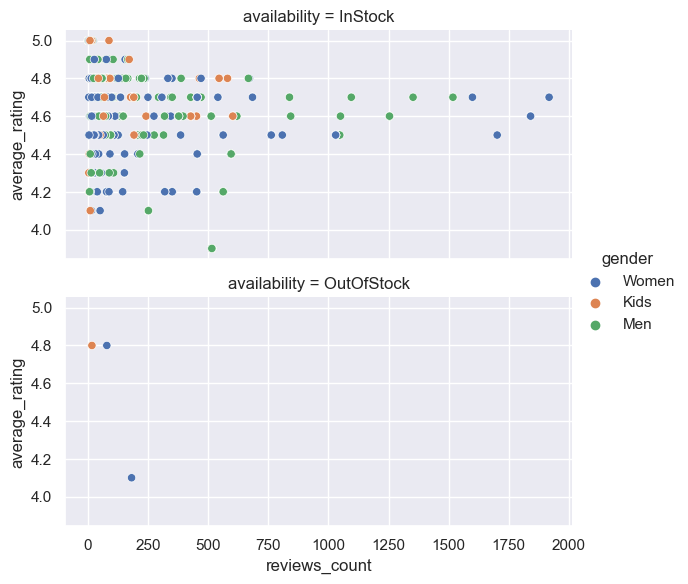

In [22]:
sns.relplot(x="reviews_count", y="average_rating", hue="gender",
            row="availability",
            data=non_outliners_data, height = 3, aspect = 2)

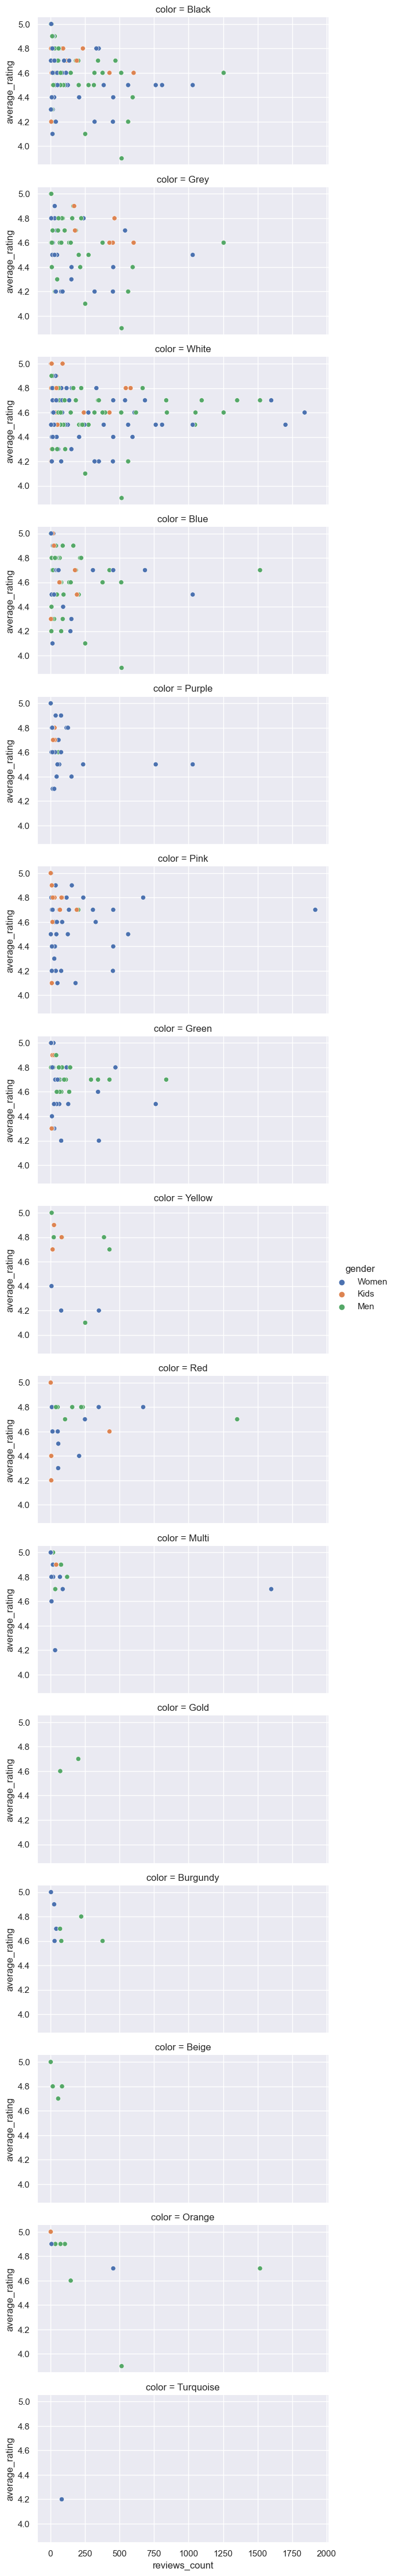

In [23]:
sns.relplot(x="reviews_count", y="average_rating", hue="gender",
            row="color",
            data=non_outliners_data, height = 3, aspect = 2)

### Conclusion on Task 2: correlation between ratings and reviews

There exists a relationship between reviews_count and average_rating score.

A negative correlation between two variables means that the variables move in opposite directions. An increase in one variable leads to a decrease in the other variable and vice versa

Due to the visualisation, we see that type of corelation on shoes category stronger, than on Clothes.
Depending on color - we see negotive corelation between reviews_count and average_rating score on white, Black and Grey color goods

# Task 3: Please create a modell to predict which combinatin of selling_price,color,category,breadcrumbs could be most popular products for next year?

Lets make the regression analysis for that purpose

The goal of regression analysis is to describe the relationship between one set of variables called the dependent variables, and another set of variables, called independent or explanatory variables

In [24]:
# Descriptive statistics are very useful for initial exploration of the variables
non_outliners_data.describe(include='all')

# categorical variables don't have some types of numerical descriptives
# and numerical variables don't have some types of categorical descriptives

,product ID,identifier,selling_price,original_price,availability,color,category,breadcrumbs,average_rating,reviews_count,gender,ageGroup,popularity
count,683.000000,683,683.000000,683.000000,683,683,683,683,683.000000,683.000000,683,683,683.000000
unique,NaN,683,NaN,NaN,2,15,3,9,NaN,NaN,3,2,NaN
top,NaN,FJ5089,NaN,NaN,InStock,White,Shoes,Women/Clothing,NaN,NaN,Women,adult,NaN
freq,NaN,1,NaN,NaN,680,175,337,161,NaN,NaN,317,584,NaN
mean,528.638360,NaN,51.754026,67.527086,NaN,NaN,NaN,NaN,4.627379,197.068814,NaN,NaN,0.923533
std,249.230857,NaN,27.602825,36.131769,NaN,NaN,NaN,NaN,0.233166,322.427349,NaN,NaN,0.060641
min,100.000000,NaN,10.000000,14.000000,NaN,NaN,NaN,NaN,3.900000,1.000000,NaN,NaN,0.768748
25%,299.500000,NaN,32.000000,40.000000,NaN,NaN,NaN,NaN,4.500000,18.000000,NaN,NaN,0.884107
50%,543.000000,NaN,48.000000,65.000000,NaN,NaN,NaN,NaN,4.700000,66.000000,NaN,NaN,0.932003
75%,746.500000,NaN,64.000000,85.000000,NaN,NaN,NaN,NaN,4.800000,222.000000,NaN,NaN,0.962582


Determining the variables of interest

<AxesSubplot:xlabel='popularity', ylabel='Density'>

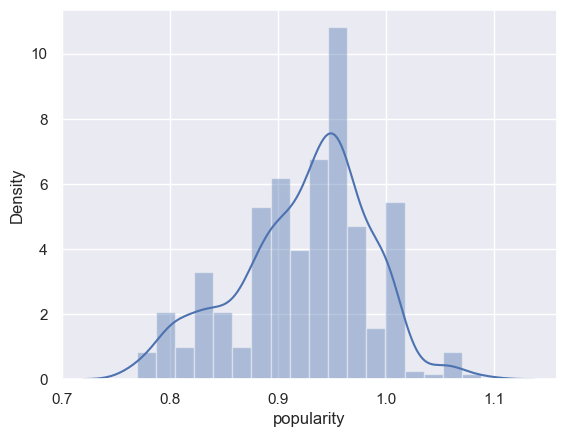

In [25]:
#display the probability distribution function (PDF) of a variable
# The PDF will show us how that variable is distributed 
# This makes it very easy to spot anomalies, such as outliers

sns.distplot(non_outliners_data['popularity'])

Checking the OLS assumptions

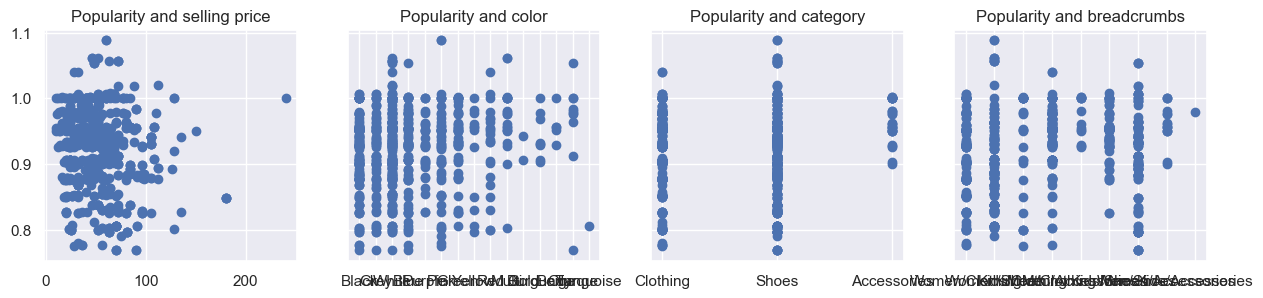

In [26]:

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize =(15,3)) 
ax1.scatter(non_outliners_data['selling_price'],non_outliners_data['popularity'])
ax1.set_title('Popularity and selling price')
ax2.scatter(non_outliners_data['color'],non_outliners_data['popularity'])
ax2.set_title('Popularity and color')
ax3.scatter(non_outliners_data['category'],non_outliners_data['popularity'])
ax3.set_title('Popularity and category')
ax4.scatter(non_outliners_data['breadcrumbs'],non_outliners_data['popularity'])
ax4.set_title('Popularity and breadcrumbs')


plt.show()

In [27]:
data_preprocessed = preproc_for_regression(non_outliners_data)

### Linear regression model

In [28]:
# Let's check the outputs of the regression
# store them in y_hat

y_hat, x_train, x_test, y_train, y_test, reg, inputs, targets = linear_regression(data_preprocessed)
y_hat

array([0.91435371, 0.91251221, 0.92147277, 0.94342415, 0.88856722,
       0.92474199, 0.92555311, 0.9189355 , 0.90056384, 0.90647606,
       0.89644223, 0.9386853 , 0.94538506, 0.91119685, 0.92147277,
       0.91946164, 0.92002007, 0.92410348, 0.89909351, 0.92644917,
       0.92265659, 0.94276291, 0.94499901, 0.92593916, 0.91762014,
       0.93393744, 0.91751056, 0.91487985, 0.92252505, 0.9160445 ,
       0.92747359, 0.94630855, 0.9396683 , 0.92500228, 0.92763424,
       0.92747359, 0.98266964, 0.9384258 , 0.91897359, 0.92642131,
       0.90251343, 0.9167048 , 0.92552842, 0.89552148, 0.90413144,
       0.91251221, 0.90740369, 0.93235902, 0.92895113, 0.92357734,
       0.91251221, 0.89910081, 0.91895745, 0.90790847, 0.92934574,
       0.94499901, 0.9350036 , 0.90623601, 0.90582526, 0.91435371,
       0.94447287, 0.94826823, 0.94565088, 0.92986221, 0.90700908,
       0.95252047, 0.9189355 , 0.92410348, 0.89502321, 0.91867521,
       0.93668757, 0.91474831, 0.89591609, 0.91910513, 0.92603

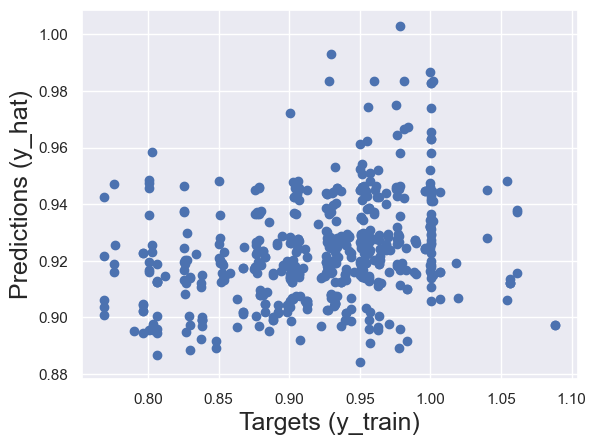

In [29]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot

plt.scatter(y_train, y_hat)

# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.show()

Text(0.5, 1.0, 'Residuals PDF')

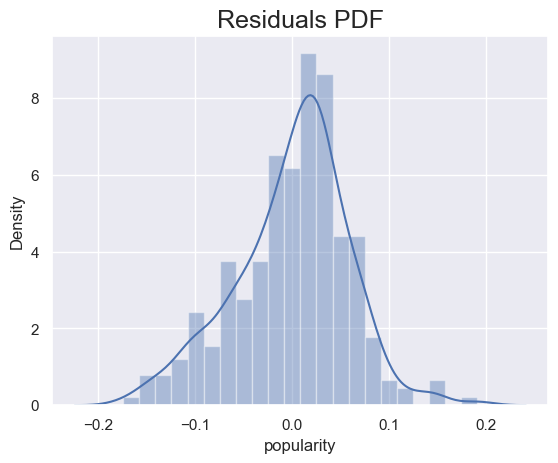

In [30]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

# plot  normally distributed


In [31]:
# Find the R-squared of the model
reg.score(x_train,y_train)

0.08742440592651268

### Finding the weights and bias

In [32]:
# Obtain the bias (intercept) of the regression
reg.intercept_

0.9235583682412195

In [33]:
# Obtain the weights (coefficients) of the regression
reg.coef_

# Note that they are barely interpretable if at all(because of dummies  and standartising)

array([-3.62809361e-03, -1.90439302e-02, -1.62302925e-02, -3.78247325e-03,
       -2.84857126e-03, -7.96737655e-03, -1.49195276e-02, -1.59607392e-03,
       -9.36429997e-04, -1.26921406e-02, -7.80892555e-03, -8.42448734e-03,
       -2.16840434e-19, -1.36554945e-02, -7.49752727e-03, -7.43359016e-03,
       -1.62539555e-02, -9.16918206e-03, -1.39712025e-02])

In [34]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,selling_price,-3.628094e-03
1,color_Black,-1.904393e-02
2,color_Blue,-1.623029e-02
3,color_Burgundy,-3.782473e-03
4,color_Gold,-2.848571e-03
5,color_Green,-7.967377e-03
6,color_Grey,-1.491953e-02
7,color_Multi,-1.596074e-03
8,color_Orange,-9.364300e-04
9,color_Pink,-1.269214e-02


# Testing

In [35]:
# Once we have trained and fine-tuned our model, we can proceed to testing it
# Testing is done on a dataset that the algorithm has never seen
# If the predictions are far off, we will know that our model overfitted

y_hat_test = reg.predict(x_test)

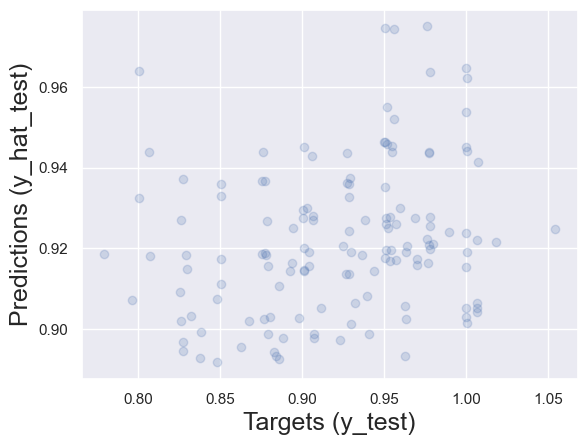

In [36]:
# Create a scatter plot with the test targets and the test predictions


plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)

plt.show()

In [37]:
# Finally, let's manually check these predictions

df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pf.head()

,Prediction
0,0.919072
1,0.964044
2,0.894102
3,0.974367
4,0.943793


In [38]:
# We can also include the test targets in that data frame (so we can manually compare them)
y_test = y_test.reset_index(drop=True)


df_pf['Target'] = y_test
df_pf


,Prediction,Target
0,0.919072,1.000596
1,0.964044,0.800340
2,0.894102,0.883086
3,0.974367,0.955703
4,0.943793,0.876277
...,...,...
132,0.918316,0.829000
133,0.915518,0.904341
134,0.902668,0.898321
135,0.926721,0.878405


In [39]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual (we already plotted the residuals)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

# Since OLS is basically an algorithm which minimizes the total sum of squared errors (residuals),
# this comparison makes a lot of sense

In [40]:
# Finally, it makes sense to see how far off we are from the result percentage-wise
# take the absolute difference in %, so we can easily order the data frame
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,0.919072,1.000596,0.081523,8.147482
1,0.964044,0.800340,-0.163704,20.454300
2,0.894102,0.883086,-0.011017,1.247519
3,0.974367,0.955703,-0.018664,1.952924
4,0.943793,0.876277,-0.067517,7.704933
...,...,...,...,...
132,0.918316,0.829000,-0.089316,10.773889
133,0.915518,0.904341,-0.011178,1.235990
134,0.902668,0.898321,-0.004347,0.483933
135,0.926721,0.878405,-0.048316,5.500455


In [41]:
# Exploring the descriptives here gives us additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,137.000000,137.000000,137.000000,137.000000
mean,0.922182,0.922055,-0.000127,4.977766
std,0.018644,0.058593,0.056858,3.994681
min,0.891619,0.779171,-0.163704,0.136976
25%,0.907267,0.879171,-0.032538,1.952924
50%,0.919462,0.928745,0.003831,3.859775
75%,0.932812,0.963556,0.038627,7.020734
max,0.975024,1.054117,0.129488,20.454300
